In [1]:
#전처리 자동화와 교차검증
import pandas as pd
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/40945
X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)
df = pd.concat([X,y],axis=1)

In [2]:
df.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'survived'],
      dtype='object')

In [3]:
train_cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']

X = df[train_cols] #독립변수
y = df['survived'] 
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

/opt/homebrew/anaconda3/envs/virt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='survived', ylabel='count'>

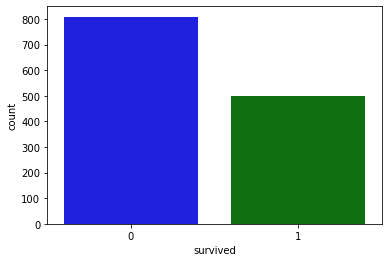

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
colors = ['blue', 'green']

sns.countplot('survived', data=df, palette=colors)

In [5]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X,y)

X_samp = pd.DataFrame(data=X_sample,columns=train_cols)
y_samp = pd.DataFrame(data=y_sample,columns=['survived'])
df2 = pd.concat([X_samp,y_samp],axis=1)

In [6]:
X = df2[train_cols] #독립변수
y = df2['survived']
y.value_counts()

0    500
1    500
Name: survived, dtype: int64

/opt/homebrew/anaconda3/envs/virt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='survived', ylabel='count'>

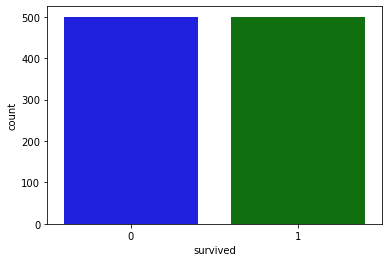

In [7]:
sns.countplot('survived', data=df2, palette=colors)

In [8]:
#데이터 전처리 자동화
#연속된 변환을 순서대로 처리하는 클래스
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

#결측값 처리 - 나이, 요금(중위수로 처리)
#스케일링
numeric_features = ['age', 'fare']
numeric_transtformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])

#범주형 변수 - 원핫인코딩
#embarked: {'C','S','Q'}
#sex: {'female','male'}
#pclass: {1,2,3}
#handle_unknown='ignore'변환 중에 에러가 발생할 경우 무시하고 계속 진행
categorical_features = ['embarked','sex','pclass']
categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num',numeric_transtformer, numeric_features),('cat',categorical_transformer,categorical_features)])

In [9]:
#전처리 후 로지스틱 회귀분석 분류모형
clf = Pipeline(steps=[('preprocessor',preprocessor),('classifier',LogisticRegression())])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'se

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y ,random_state=0)

In [12]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'se

In [13]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.76625
0.775


In [14]:
#교차검증과 모형의 튜닝
#하이퍼 파라미터 최적화
from sklearn.model_selection import GridSearchCV

#숫자 결측값 처리
#Cost
param_grid = {
    'preprocessor__num__imputer__strategy' : ['mean','median'],
    'classifier__C' : [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X,y)
grid_search.cv_results_['params']

[{'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 100, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 100, 'prep

In [15]:
scores = grid_search.cv_results_['mean_test_score']
scores

array([0.727, 0.728, 0.748, 0.748, 0.75 , 0.75 , 0.754, 0.75 , 0.754,
       0.753, 0.754, 0.753, 0.754, 0.753])

0.7540000000000001


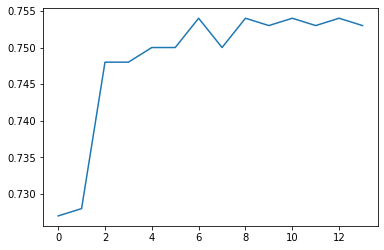

In [16]:
print(max(scores))
plt.plot(scores)

In [ ]:
#{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'},

In [17]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7540000000000001
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}
